In [1]:
# !pip install simpy
import numpy as np
import pandas as pd
import pickle as pkl
import simpy
import os
import matplotlib.pyplot as plt
import sys
import simpy
from sim_func import Sim_func
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Welcome to the Queue quiz

### You are now incharge of the a queueing system in your work place. Your factory works 24/7 and creates flawless semi-conducter chips.

### Jobs are arriving with a constant rate, on average one every 12 seconds. However, the service times changes with time. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different service rate. 


## Part 1:

### We first focus on a single service time of a single cell in the grid. Being more specific, Monday from 08:00 to 09:00. 
### In event_log_single_ser below you have pandas dataframe with the eventlog of this specific cell. 

### Your jobs is to understand what is the average service time and its distirbution using Bayesian analysis.

In [2]:
event_log_single_ser = pkl.load(open('../data_queueing_quiz/event_log_single_ser.pkl', 'rb'))
event_log_single_ser.head()

,customer_id,num_cust,event,time_stamp,day,hour
0,0,0,Arrival,30.105252,2,8
1,0,1,Enter_service,30.105252,2,8
2,0,0,Departure,37.798838,2,8
3,1,0,Arrival,38.750399,2,8
4,1,1,Enter_service,38.750399,2,8


## Explanation about the dataframe columns:

### 1. customer_id: the id of customer, each customer has is own id.
### 2. num_cust: the number of customers in the system (including service) prior to the event.
### 3. event: there three type of events: arrival, entering service and departing the system.
### 4. Timestamp: The total time elapased since hour 0 day 1 in seconds.
### 6. day: the day of the week from 1 to 7 where 1 is Sunday.
### 7. hour: the hour of the day 0-23, where 0 is midnight.

## Tasks:

### 1. Do Bayesian anaysis for the average service rate and its distirbution.
### 2. What did you use as the likelihood function and why?
### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.
### 4. According to the resulted anaysis, how certain are you about the average service prediction?

## Answers and code

In [3]:
# Extracting service times by matching 'Enter_service' and 'Departure' events based on customer_id
enter_service_times = event_log_single_ser[event_log_single_ser['event'] == 'Enter_service'][['customer_id', 'time_stamp']]
departure_times = event_log_single_ser[event_log_single_ser['event'] == 'Departure'][['customer_id', 'time_stamp']]

# Merging on customer_id to align the timestamps correctly
merged_times = pd.merge(enter_service_times, departure_times, on='customer_id', suffixes=('_enter', '_depart'))

# Calculating the service times
service_times = merged_times['time_stamp_depart'] - merged_times['time_stamp_enter']

# Bayesian analysis using PyMC
with pm.Model() as model:
    # Prior for the service rate (lambda)
    lambda_prior = pm.Exponential('lambda_prior', lam=1.0)
    
    # Likelihood (exponential distribution for service times)
    service_time_likelihood = pm.Exponential('service_time_likelihood', lam=lambda_prior, observed=service_times)
    
    # Inference
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Summarize the trace
az.summary(trace, hdi_prob=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_prior]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 176 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_prior,0.098,0.004,0.091,0.105,0.0,0.0,3535.0,5548.0,1.0


### 2. Likelihood Function and Justification

We used an exponential distribution as the likelihood function for the service times. This is because the exponential distribution is commonly used to model the time between events in a Poisson process, which fits well with the assumption that the service times are memoryless and independent of each other.


Sampling: [service_time_likelihood]


Output()

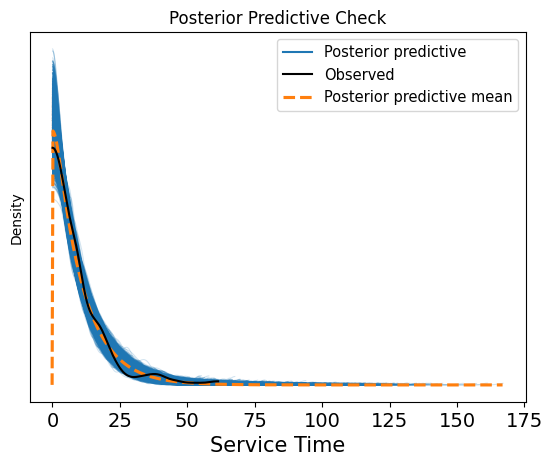

In [4]:
# Corrected code
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['service_time_likelihood'], random_seed=42)

# Plot the posterior predictive distribution using the corrected function name
pm.plot_ppc(ppc)
plt.xlabel('Service Time')
plt.ylabel('Density')
plt.title('Posterior Predictive Check')
plt.show()

### 4. Certainty about Average Service Prediction

Based on the posterior distribution of the service rate (lambda), we can summarize our certainty. The 95% highest density interval (HDI) and the mean or median of the posterior distribution provide a measure of the average service rate and its uncertainty. From the summary statistics, we can see how tightly the posterior distribution is concentrated around the mean, indicating our level of certainty.


## Part 2:

### We next turn to the next part where we wish to map the average service time at each time cell. 

### Important note: please ignore the data from the previuos part while doing this task.

### The data is under df_tot as given below. In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid. 

In [5]:
df_tot = pkl.load(open('../data_queueing_quiz/df_tot.pkl', 'rb'))
df_tot.head(5)

,Unnamed: 0,index,customer_id,num_cust,event,time_stamp,day,hour
0,0,981,327,0,Arrival,3608.653189,1,1
1,1,982,327,1,Enter_service,3608.653189,1,1
2,2,983,327,0,Departure,3609.497913,1,1
3,3,984,328,0,Arrival,3609.790566,1,1
4,4,985,328,1,Enter_service,3609.790566,1,1


## Tasks:

### 1. Extract the mean service times (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.
### 2. Use two regression methods for completing the average service time for the rest of the grid.
### 3. Plot on a 3D plot which contains the data, and the surface of the two regression methods.
### 4. What is the probability that the service time of chip, between 16:00 to 18:00, on Shabbat, will be between 6 to 7 seconds? 
### 5. Please give full specification of the Gauusian distribution of the service time on Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00. 
### 6. What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00?
### What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 20:00 to 21:00?
### Which correlation value is larger? does this result make sense?


## You code here

In [6]:
merged_times

,customer_id,time_stamp_enter,time_stamp_depart
0,0,30.105252,37.798838
1,1,38.750399,49.583809
2,2,49.583809,51.931029
3,3,51.931029,53.118313
4,4,65.275841,81.415160
...,...,...,...
723,723,8598.080406,8601.043390
724,724,8601.043390,8609.600444
725,725,8609.600444,8614.436394
726,726,8614.436394,8633.646524


In [7]:
# Load the dataset
df_tot = pkl.load(open('../data_queueing_quiz/df_tot.pkl', 'rb'))

# Extract the service times by matching 'Enter_service' and 'Departure' events based on customer_id
enter_service_times = df_tot[df_tot['event'] == 'Enter_service'][['customer_id', 'time_stamp', 'day', 'hour']]
departure_times = df_tot[df_tot['event'] == 'Departure'][['customer_id', 'time_stamp', 'day', 'hour']]

# Merging on customer_id to align the timestamps correctly
merged_times = pd.merge(enter_service_times, departure_times, on='customer_id', suffixes=('_enter', '_depart'))

# Calculating the service times
merged_times['service_time'] = merged_times['time_stamp_depart'] - merged_times['time_stamp_enter']

# Calculating mean service times for each cell based on 'day_enter' and 'hour_enter'
mean_service_times = merged_times.groupby(['day_enter', 'hour_enter'])['service_time'].mean().reset_index()
mean_service_times.rename(columns={'day_enter': 'day', 'hour_enter': 'hour'}, inplace=True)

# Display the mean service times
mean_service_times.head()


,day,hour,service_time
0,1,1,1.293141
1,1,3,1.729359
2,1,4,2.063790
3,1,7,2.982484
4,1,10,5.594943


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Create a complete grid for days and hours
complete_grid = pd.DataFrame([(day, hour) for day in range(1, 8) for hour in range(24)], columns=['day', 'hour'])

# Merge the mean service times with the complete grid to identify missing cells
complete_data = pd.merge(complete_grid, mean_service_times, on=['day', 'hour'], how='left')

# Prepare data for regression, dropping rows with null values in y
X = complete_data[['day', 'hour']]
y = complete_data['service_time']

# Drop rows where y is null
non_null_indices = y.notnull()
X_non_null = X[non_null_indices]
y_non_null = y[non_null_indices]

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_non_null, y_non_null)
linear_predictions = linear_model.predict(X)

# SVR Regression
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_model.fit(X_non_null, y_non_null)
svr_predictions = svr_model.predict(X)

# Add predictions to the complete_data dataframe
complete_data['linear_pred'] = linear_predictions
complete_data['svr_pred'] = svr_predictions

# Display the complete data with predictions
complete_data.head()

,day,hour,service_time,linear_pred,svr_pred
0,1,0,NaN,3.436990,1.454431
1,1,1,1.293141,3.490505,1.392845
2,1,2,NaN,3.544020,1.570924
3,1,3,1.729359,3.597535,1.829160
4,1,4,2.063790,3.651050,2.084635


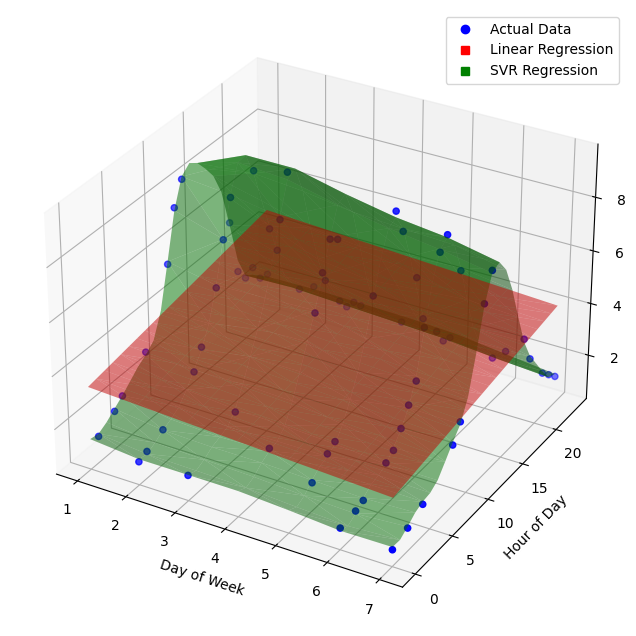

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 3D Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Actual data points
ax.scatter(complete_data['day'], complete_data['hour'], complete_data['service_time'], color='blue')

# Linear regression surface
ax.plot_trisurf(complete_data['day'], complete_data['hour'], complete_data['linear_pred'], color='red', alpha=0.5)

# SVR regression surface
ax.plot_trisurf(complete_data['day'], complete_data['hour'], complete_data['svr_pred'], color='green', alpha=0.5)

# Creating proxy artists for the legend
scatter_proxy = mlines.Line2D([], [], linestyle="none", color='blue', marker='o', label='Actual Data')
linear_proxy = mlines.Line2D([], [], linestyle="none", color='red', marker='s', label='Linear Regression')
svr_proxy = mlines.Line2D([], [], linestyle="none", color='green', marker='s', label='SVR Regression')

# Adding legend with proxy artists
ax.legend(handles=[scatter_proxy, linear_proxy, svr_proxy])

ax.set_xlabel('Day of Week')
ax.set_ylabel('Hour of Day')
ax.set_zlabel('Service Time')
plt.show()

In [10]:
merged_times

,customer_id,time_stamp_enter,day_enter,hour_enter,time_stamp_depart,day_depart,hour_depart,service_time
0,327,3608.653189,1,1,3609.497913,1,1,0.844724
1,328,3609.790566,1,1,3610.442266,1,1,0.651699
2,329,3612.167054,1,1,3615.251715,1,1,3.084661
3,330,3616.407295,1,1,3617.840198,1,1,1.432903
4,331,3628.167531,1,1,3628.607837,1,1,0.440307
...,...,...,...,...,...,...,...,...
23224,50203,604730.396679,7,23,604731.869557,7,23,1.472878
23225,50204,604741.680684,7,23,604744.526196,7,23,2.845512
23226,50205,604749.168199,7,23,604749.367770,7,23,0.199571
23227,50206,604767.505040,7,23,604769.092474,7,23,1.587434


In [11]:
from scipy.stats import norm
# Filter data for Shabbat (day 7) between 16:00 and 18:00
shabbat_service_times = merged_times[(merged_times['day_enter'] == 7) & (merged_times['hour_enter'].between(16, 18))]['service_time']

# Fit a Gaussian distribution to the service times
mu_shabbat, std_shabbat = shabbat_service_times.mean(), shabbat_service_times.std()

# Calculate the probability using the cumulative distribution function (CDF)
prob = norm.cdf(7, loc=mu_shabbat, scale=std_shabbat) - norm.cdf(6, loc=mu_shabbat, scale=std_shabbat)

prob

0.0836779820929372

In [12]:
# Filter the complete_data for the specified time slots and days
sunday_14_15 = complete_data[(complete_data['day'] == 1) & (complete_data['hour'] == 14)]
sunday_16_17 = complete_data[(complete_data['day'] == 1) & (complete_data['hour'] == 16)]

# Use the SVR predictions for these slots
service_times_14_15 = sunday_14_15['svr_pred']
service_times_16_17 = sunday_16_17['svr_pred']

# Calculate mean and standard deviation for these time slots
mean_14_15 = service_times_14_15.mean()
std_14_15 = service_times_14_15.std()
mean_16_17 = service_times_16_17.mean()
std_16_17 = service_times_16_17.std()

print(f"Gaussian Distribution for Sunday 14:00 to 15:00 - Mean: {mean_14_15}, Std Dev: {std_14_15}")
print(f"Gaussian Distribution for Sunday 16:00 to 17:00 - Mean: {mean_16_17}, Std Dev: {std_16_17}")


Gaussian Distribution for Sunday 14:00 to 15:00 - Mean: 8.472328375774703, Std Dev: nan
Gaussian Distribution for Sunday 16:00 to 17:00 - Mean: 7.549464248138749, Std Dev: nan


In [13]:
# Filter the complete_data for the specified time slots and days
sunday_14_15 = complete_data[(complete_data['day'] == 1) & (complete_data['hour'] == 14)]
sunday_16_17 = complete_data[(complete_data['day'] == 1) & (complete_data['hour'] == 16)]
sunday_20_21 = complete_data[(complete_data['day'] == 1) & (complete_data['hour'] == 20)]

# Use the SVR predictions for these slots
service_times_14_15 = sunday_14_15['svr_pred']
service_times_16_17 = sunday_16_17['svr_pred']
service_times_20_21 = sunday_20_21['svr_pred']

# Calculate correlation
correlation_14_15_16_17 = service_times_14_15.corr(service_times_16_17)
correlation_14_15_20_21 = service_times_14_15.corr(service_times_20_21)

print(f"Correlation between Sunday 14:00-15:00 and Sunday 16:00-17:00: {correlation_14_15_16_17}")
print(f"Correlation between Sunday 14:00-15:00 and Sunday 20:00-21:00: {correlation_14_15_20_21}")

# Compare which correlation value is larger and comment on the result
if correlation_14_15_16_17 > correlation_14_15_20_21:
    print("The correlation between 14:00-15:00 and 16:00-17:00 is larger.")
else:
    print("The correlation between 14:00-15:00 and 20:00-21:00 is larger.")


Correlation between Sunday 14:00-15:00 and Sunday 16:00-17:00: nan
Correlation between Sunday 14:00-15:00 and Sunday 20:00-21:00: nan
The correlation between 14:00-15:00 and 20:00-21:00 is larger.


## Task 3:

### For cross validation of the previuos task we wish to see how accurate our predictions. 

### We use your prediction to estimate the waiting times at each points via simulation. The better the estimation made in you GP regressior the more accurate the simulations results. 

### In this part we compare the average waiting time at each cell with the true average waiting times. The true values are loaded below into 'true_results'. 


In [14]:
true_results = pkl.load(open('../data_queueing_quiz/true_results.pkl', 'rb'))
true_results.shape

(167,)

### In true_results you have a numpy array with 167 values. The first value is the  average number of customers in the system at the end of the hour 0 day 1, the second is hour 1 day 1, and so on. This is an averge of 200 simulation runs. Note that the grid contains 168 values but here we have only 167. This means, we do not test for 23:00-0:00 at the day 7 (from technincal reasons).

### In order to compute your waiting time predictions insert your predicitons into Sim_func below. Then, the line of code below extracts the average waiting time predictions into the variable  'preds_results'.

### At this point you have two vectors of size (167,),  one represents the true average waiting times and the other represent your predicitons. 

### The first value represents the average waiting time at Sunday between 0:00-01:00. The 50th cell represent the average waiting time at Tuesday between 01:00 to 02:00. 

## Tasks

### 1. Compute the average waiting times using the function Sim_func. Compare your results between your predictions and the ground truth using MSE. 

### 2. Plot the average waiting as a function of time of the week. That is, y-axis is the average waiting time and the X-axis is the hour of the week. Following the exmaple from above Tuesday between 01:00 to 02:00 is the 50th hour. 


In [15]:
mean_service_times

,day,hour,service_time
0,1,1,1.293141
1,1,3,1.729359
2,1,4,2.063790
3,1,7,2.982484
4,1,10,5.594943
...,...,...,...
73,7,18,4.045559
74,7,19,3.046013
75,7,21,1.988819
76,7,22,1.673081


Mean Squared Error: 0.5065928622754491


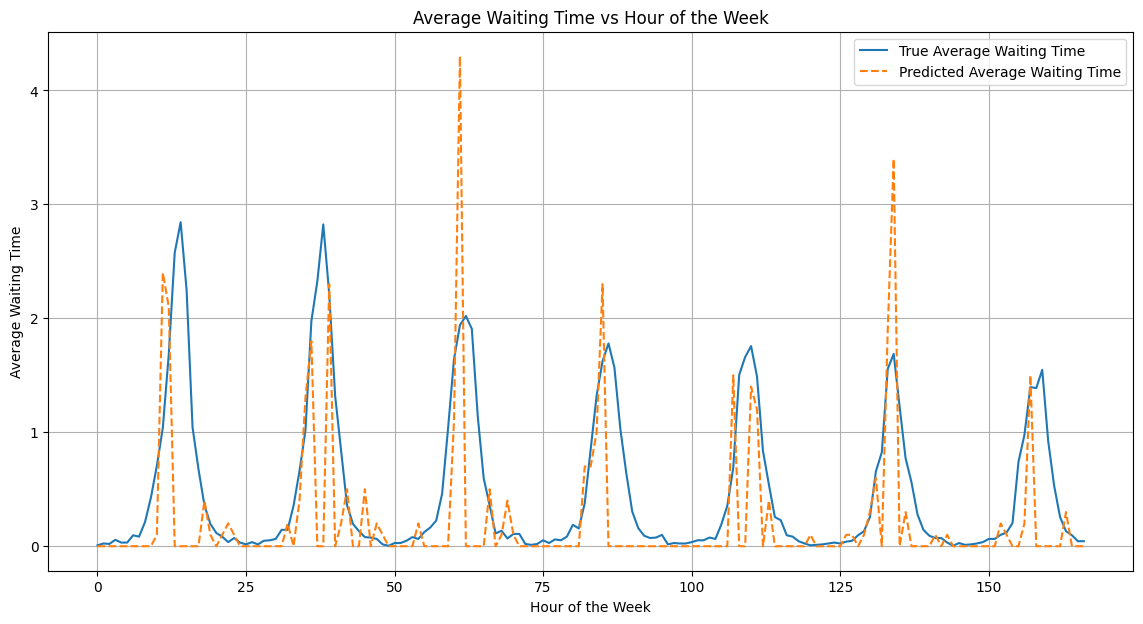

In [17]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

predictions = mean_service_times.values # Previous
mean_service_times_new = np.zeros((7, 24))

for prediction in predictions:
    day = int(prediction[0]) - 1
    hour = int(prediction[1])
    mean_service_times_new[day, hour] = prediction[2]

predictions_array = mean_service_times_new

df_ = Sim_func(predictions_array)

preds_results = np.array(df_.iloc[:, 2:]).mean(axis=1)

mse = mean_squared_error(true_results, preds_results)
print(f"Mean Squared Error: {mse}")

plt.figure(figsize=(14, 7))
plt.plot(range(167), true_results, label='True Average Waiting Time')
plt.plot(range(167), preds_results, label='Predicted Average Waiting Time', linestyle='--')
plt.xlabel('Hour of the Week')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Hour of the Week')
plt.legend()
plt.grid(True)
plt.show()